In [1]:
import torch
from diffusers import DiffusionPipeline
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import requests

# Load the stable-diffusion model
pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True)
print('Model loaded')



/home/scpark/anaconda3/envs/ste/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-12 15:05:26.641566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 15:05:28.066632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading pipeline components...: 100%|█████████████| 7/7 [00:01<00:00,  4.39it/s]

Model loaded


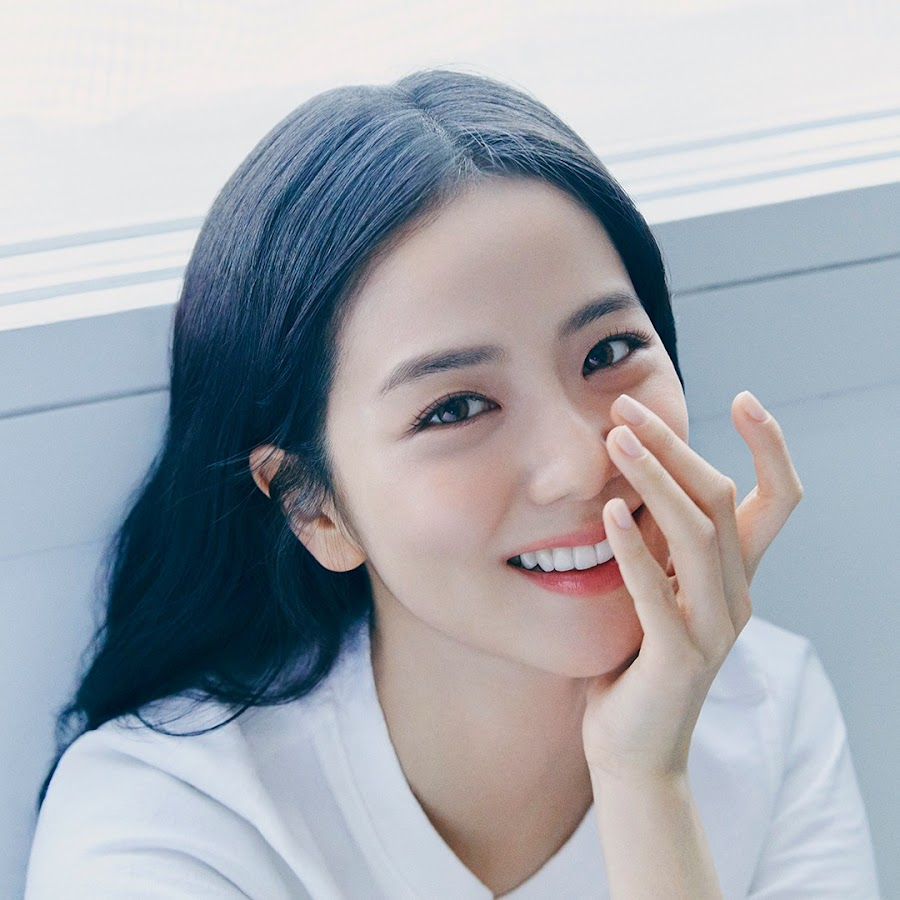

In [2]:
from io import BytesIO

# URL of a well-known image
image_url = "https://yt3.googleusercontent.com/fm20iirArjtnCBu_vFjNlR87991BsH5MKlVEYPWstlT6XnCqMrgOaSgeQm9ovJGEx9h6qSDI2w=s900-c-k-c0x00ffffff-no-rj"

# Load the image
response = requests.get(image_url)
response.raise_for_status()  # Check if the request was successful
image_data = response.content
original_image = Image.open(BytesIO(image_data)).convert("RGB")
original_image

In [3]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

image_tensor = preprocess(original_image).unsqueeze(0)  # Add batch dimension
print(image_tensor.shape)

# Encode the image to latent space
latent = pipeline.vae.encode(image_tensor).latent_dist.sample()
print(latent.shape)

# Decode the latent space back to image
reconstructed_image = pipeline.vae.decode(latent).sample
reconstructed_image = ((reconstructed_image + 1) * 127.5).clamp(0, 255).to(torch.uint8)
print(reconstructed_image.shape)
reconstructed_image = Image.fromarray(reconstructed_image.permute(0, 2, 3, 1)[0].data.cpu().numpy())


torch.Size([1, 3, 900, 900])
torch.Size([1, 4, 112, 112])
torch.Size([1, 3, 896, 896])


/tmp/ipykernel_2533/562236641.py:8: FutureWarning: Accessing config attribute `scaling_factor` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'scaling_factor' over 'AutoencoderKL's config object instead, e.g. 'unet.config.scaling_factor'.
  axes[1].imshow(latent.permute(0, 2, 3, 1)[0, :, :, :3].cpu().detach().numpy() * pipeline.vae.scaling_factor, cmap='gray')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


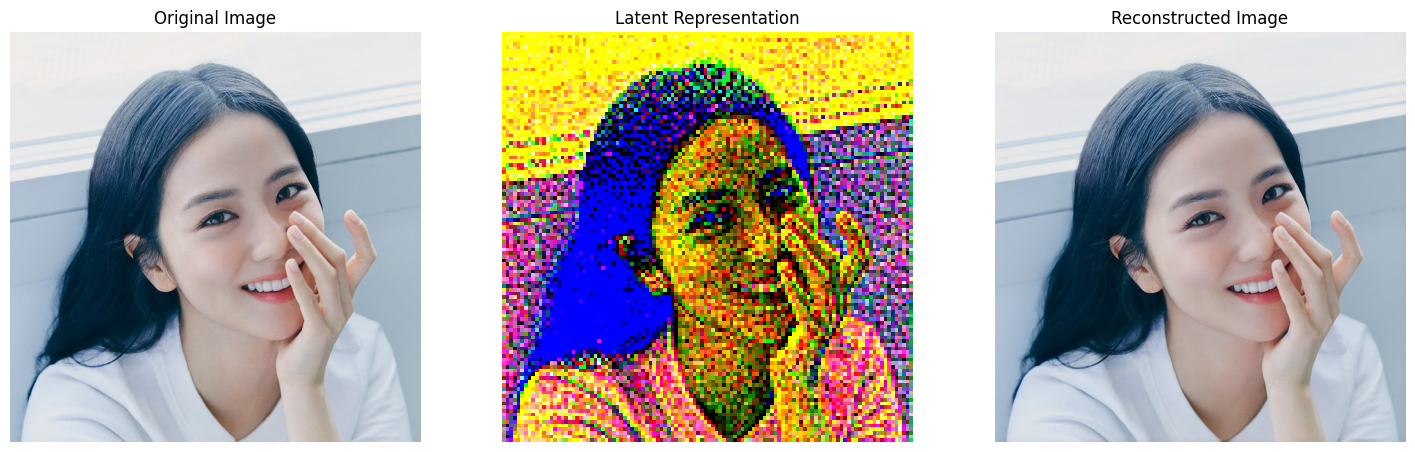

In [4]:
# Plotting the original, latent and reconstructed images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(latent.permute(0, 2, 3, 1)[0, :, :, :3].cpu().detach().numpy() * pipeline.vae.scaling_factor, cmap='gray')
axes[1].set_title('Latent Representation')
axes[1].axis('off')

axes[2].imshow(reconstructed_image)
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')

plt.show()


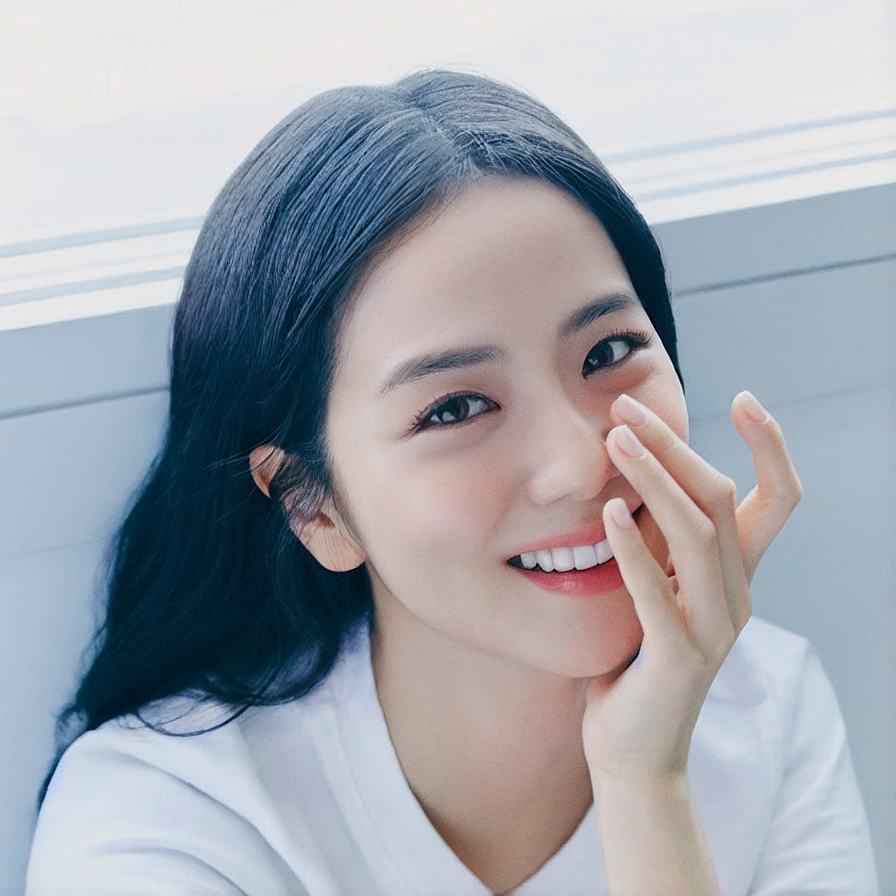

In [5]:
reconstructed_image